Week 6 · Day 6 — Overfitting & Underfitting
Why this matters

In deep nets, models can be too simple (underfit) or too complex (overfit). Knowing how to diagnose and fix these cases is a core DL skill.

Theory Essentials

Underfitting:

High train loss, high val loss.

Model is too simple, not enough capacity.

Overfitting:

Low train loss, high val loss.

Model memorizes training set, fails to generalize.

Diagnostics: compare train vs val curves.

Fix underfitting: bigger net, train longer, lower regularization.

Fix overfitting: dropout, weight decay, more data, early stopping.

Training small net
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Training large net
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


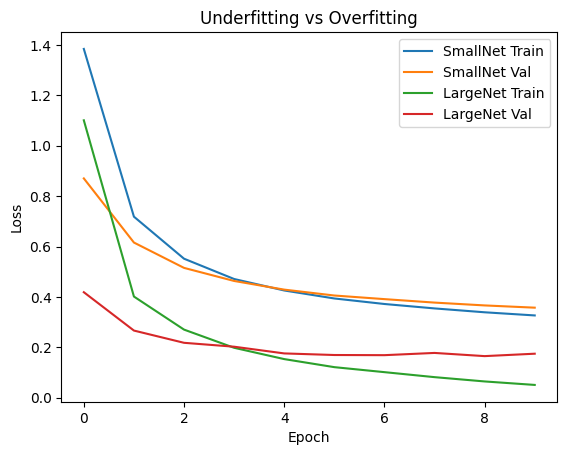

In [1]:
# Setup
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

torch.manual_seed(42)

# ---------- Data ----------
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
train_data, val_data = random_split(dataset, [10000, 50000])  # small train set to force overfit
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=1000)

# ---------- Models ----------
class SmallNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28*28, 10)  # linear classifier only
    def forward(self,x):
        return self.fc(x.view(-1,28*28))

class LargeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,128)
        self.fc4 = nn.Linear(128,10)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(0.5)
    def forward(self,x):
        x = x.view(-1,28*28)
        x = self.relu(self.fc1(x))
        x = self.drop(self.relu(self.fc2(x)))
        x = self.drop(self.relu(self.fc3(x)))
        return self.fc4(x)

# ---------- Train & Eval ----------
def train(model, epochs=10):
    opt = optim.Adam(model.parameters(), lr=0.001)
    crit = nn.CrossEntropyLoss()
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        # Train
        model.train(); total=0
        for X,y in train_loader:
            opt.zero_grad()
            loss = crit(model(X),y)
            loss.backward(); opt.step()
            total += loss.item()
        train_losses.append(total/len(train_loader))
        print("Epoch", epoch + 1)
        # Val
        model.eval(); vloss=0
        with torch.no_grad():
            for X,y in val_loader:
                vloss += crit(model(X),y).item()
        val_losses.append(vloss/len(val_loader))
    return train_losses,val_losses

print("Training small net")
small_train, small_val = train(SmallNet())

print("Training large net")
large_train, large_val = train(LargeNet())

# ---------- Plot ----------
plt.plot(small_train,label="SmallNet Train"); plt.plot(small_val,label="SmallNet Val")
plt.plot(large_train,label="LargeNet Train"); plt.plot(large_val,label="LargeNet Val")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.title("Underfitting vs Overfitting")
plt.show()


Exercises

1) Core (10–15 min)
Task: Run both models. Which one underfits, which one overfits?

Underfitting → both training and validation losses are high and decrease only slowly.
🔹 That’s what happens with the SmallNet (blue/orange): it struggles to learn the patterns, even training loss doesn’t go very low.

Overfitting → training loss keeps dropping, but validation loss stops improving (or gets worse).
🔹 That’s what happens with the LargeNet (green/red): training loss → almost 0, but validation loss flattens and even ticks upward a bit after ~epoch 6 → classic overfit.

Good fit → both training and validation losses are low and close to each other.
🔹 Neither model here hits the sweet spot fully, but LargeNet performs better up to a point before overfitting kicks in.

👉 Rule of thumb from loss curves:

High loss for both train + val → underfitting.

Big gap (train ≪ val) → overfitting.

Low + close losses → good generalization.

2) Practice (10–15 min)
Task: Add weight decay (1e-4) to LargeNet optimizer. Does validation loss improve?

Training large net weight decay
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10


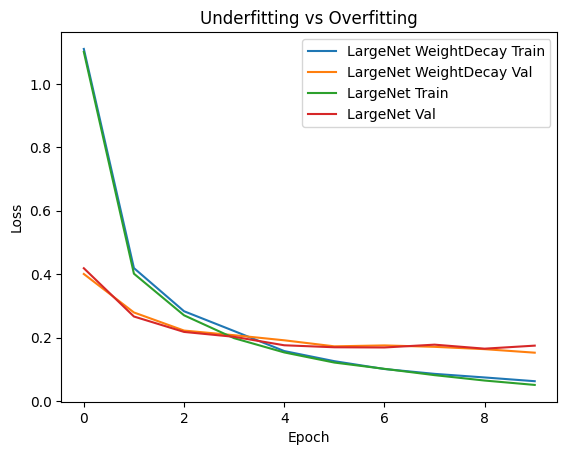

In [3]:
def train2(model, epochs=10):
    opt = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    crit = nn.CrossEntropyLoss()
    train_losses, val_losses = [], []
    for epoch in range(epochs):
        # Train
        model.train(); total=0
        for X,y in train_loader:
            opt.zero_grad()
            loss = crit(model(X),y)
            loss.backward(); opt.step()
            total += loss.item()
        train_losses.append(total/len(train_loader))
        print("Epoch", epoch + 1)
        # Val
        model.eval(); vloss=0
        with torch.no_grad():
            for X,y in val_loader:
                vloss += crit(model(X),y).item()
        val_losses.append(vloss/len(val_loader))
    return train_losses,val_losses

print("Training large net weight decay")
large_train_wd, large_val_wd = train2(LargeNet())

# ---------- Plot ----------
plt.plot(large_train_wd,label="LargeNet WeightDecay Train")
plt.plot(large_val_wd,label="LargeNet WeightDecay Val")

plt.plot(large_train,label="LargeNet Train")
plt.plot(large_val,label="LargeNet Val")

plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.title("Underfitting vs Overfitting")
plt.show()


You cant really appreciate the difference between having or not weight decay. This means the model is strongly overfitting or either weight decay is very small. 

3) Stretch (optional, 10–15 min)
Task: Add early stopping to LargeNet: stop training when val loss hasn’t improved for 3 epochs. Compare to full 10-epoch run.

Training LargeNet with early stopping
Epoch 01: train 1.1161 | val 0.4049
Epoch 02: train 0.4092 | val 0.2943
Epoch 03: train 0.2760 | val 0.2382
Epoch 04: train 0.2070 | val 0.1993
Epoch 05: train 0.1611 | val 0.1809
Epoch 06: train 0.1315 | val 0.1667
Epoch 07: train 0.1118 | val 0.1791
Epoch 08: train 0.0818 | val 0.1710
Epoch 09: train 0.0724 | val 0.1634
Epoch 10: train 0.0556 | val 0.1710
Epoch 11: train 0.0402 | val 0.1752
Epoch 12: train 0.0344 | val 0.1769
Early stopping at epoch 12 (best epoch 9, best val 0.1634)
Training large net
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


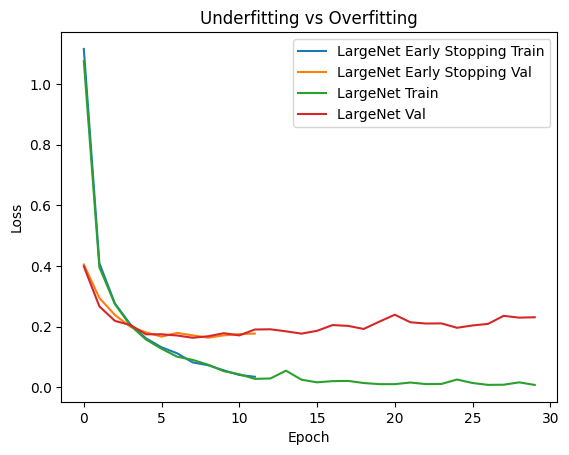

In [ ]:
from copy import deepcopy
import torch, torch.nn as nn, torch.optim as optim

def train_with_early_stopping(model, epochs=10, patience=3, min_delta=0.0):
    """
    Train like your `train()` but stop early on val loss.
    Returns: train_losses, val_losses, best_epoch
    """
    opt = optim.Adam(model.parameters(), lr=0.001)
    crit = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    best_val = float("inf")
    best_state = None
    best_epoch = -1
    epochs_no_improve = 0

    for epoch in range(epochs):
        # ---- train ----
        model.train(); total = 0.0
        for X, y in train_loader:
            opt.zero_grad()
            loss = crit(model(X), y)
            loss.backward(); opt.step()
            total += loss.item()
        train_loss = total / len(train_loader)

        # ---- validate ----
        model.eval(); vloss = 0.0
        with torch.no_grad():
            for X, y in val_loader:
                vloss += crit(model(X), y).item()
        val_loss = vloss / len(val_loader)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch+1:02d}: train {train_loss:.4f} | val {val_loss:.4f}")

        # ---- early stopping logic ----
        if best_val - val_loss > min_delta:
            best_val = val_loss
            best_state = deepcopy(model.state_dict())
            best_epoch = epoch
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1} (best epoch {best_epoch+1}, best val {best_val:.4f})")
                break

    # restore best weights (if we ever improved)
    if best_state is not None:
        model.load_state_dict(best_state)

    return train_losses, val_losses, best_epoch


print("Training LargeNet with early stopping")
large_es_model = LargeNet()
large_es_train, large_es_val, best_ep = train_with_early_stopping(large_es_model, epochs=30, patience=3, min_delta=0.0)

print("Training large net")
large_train, large_val = train(LargeNet(), epochs=30)

# ---------- Plot ----------
plt.plot(large_es_train,label="LargeNet Early Stopping Train")
plt.plot(large_es_val,label="LargeNet Early Stopping Val")

plt.plot(large_train,label="LargeNet Train")
plt.plot(large_val,label="LargeNet Val")

plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.title("Underfitting vs Overfitting")
plt.show()



Mini-Challenge (≤40 min)

Task: Train LargeNet with and without dropout.

Plot train vs val accuracy.

Report if dropout reduced overfitting.

Write 2–3 sentences: tradeoff between slower learning and better generalization.

Acceptance Criteria:

Two accuracy curves.

One short reflection on dropout’s effect.

Training LargeNet with dropout
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


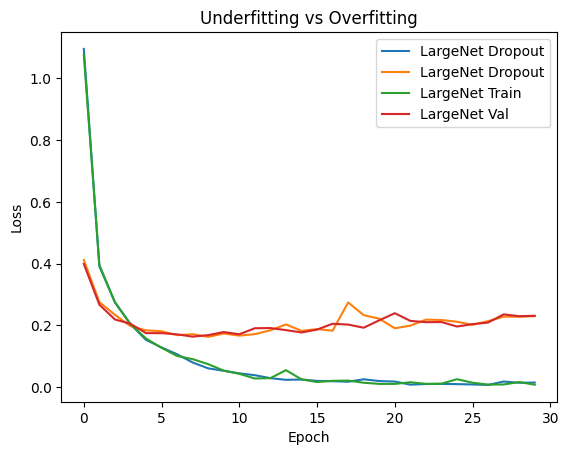

In [8]:
class LargeNetDrop(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.drop = nn.Dropout(p)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.drop(self.relu(self.fc2(x)))
        x = self.drop(self.relu(self.fc3(x)))
        return self.fc4(x)
    

print("Training LargeNet with dropout")
large_drop_model = LargeNetDrop()
large_drop_train, large_drop_val = train(large_drop_model, epochs=30)


# ---------- Plot ----------
plt.plot(large_drop_train,label="LargeNet Dropout")
plt.plot(large_drop_val,label="LargeNet Dropout")

plt.plot(large_train,label="LargeNet Train")
plt.plot(large_val,label="LargeNet Val")

plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.legend(); plt.title("Underfitting vs Overfitting")
plt.show()



Dropout didn't really change the result.

Notes / Key Takeaways

Underfit = not enough capacity; overfit = too much capacity.

Train vs val curves = your primary diagnostic tool.

Regularization (dropout, weight decay) combats overfitting.

More capacity + more data = better balance.

Early stopping is a practical safeguard.

Reflection

What curve patterns show underfitting vs overfitting?

Why is it useful to deliberately train a too-big model and then regularize it, instead of always using small models?

What curve patterns show underfitting vs overfitting?

Underfitting: both training and validation losses stay high and close together (the model can’t capture the patterns).

Overfitting: training loss keeps going down, but validation loss flattens or starts rising (the model memorizes instead of generalizing).

Why is it useful to deliberately train a too-big model and then regularize it, instead of always using small models?

Larger models have enough capacity to capture complex patterns. With regularization (dropout, weight decay, early stopping), we can control overfitting while keeping that capacity.

Small models risk underfitting because they simply can’t represent the data’s complexity, even if trained perfectly.